In [1106]:
import numpy as np
import fnmatch
import os
import pickle
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("../")
from task import CircleSearch

In [1107]:
_COLORS = ['red', 'orange', 'yellow', 'limegreen', 'lightseagreen', 'skyblue', 'cornflowerblue', 'purple', 'pink']

# Reading in data

In [1194]:
data_dir = '../logs/search/0/'

In [1195]:
def get_trials_list(dir, fltr='*[!t][!x][!t]'):
    all_trials = []
    for root, dirnames, filenames in os.walk(dir):
        for filename in fnmatch.filter(filenames, fltr):
            with open(os.path.join(root, filename), 'rb') as f:
                all_trials.append(json.load(f))
    return all_trials

In [1196]:
all_trials = get_trials(data_dir)

In [1198]:
len(all_trials)

125

In [1199]:
def _extract_kv(key, val, arr):
    """Recursively unpacks item to turn a single key value pair. Meant to address dictionary value entries
    """    
    if type(val) is dict:
        for nested_key in val.keys():
            nested_val = val[nested_key]      
            arr = _extract_kv(nested_key, nested_val, arr)
    else:
        arr.append((key, val))
    return arr
    

In [1200]:
def get_step_dict(steps):
    step_dicts = []
    for trial in steps:
        step_dict = {}
        for step in trial:
            for item in step: 
                kv_arr = _extract_kv(item[0], item[1], [])
                for key, val in kv_arr:                    
                    if key not in step_dict:
                        step_dict[key] = []
                    step_dict[key].append(val)
        step_dicts.append(step_dict)
    return step_dicts

def get_state_dict(states):
    state_dicts = []
    for trial in states:
        state_dict = {}
        for step in trial:
            for sprite, sprite_attr in step:
                if sprite not in state_dict.keys():            
                    state_dict[sprite] = []
                state_dict[sprite].append(sprite_attr)
        state_dicts.append(state_dict)
    return state_dicts

In [1201]:
steps = []
states = []
for trial in all_trials:
    trial_steps, trial_states = [], []
    for step in trial:
        trial_steps.append(step[:5])
        trial_states.append(step[-1])
    steps.append(trial_steps)
    states.append(trial_states)
steps = get_step_dict(steps)
states = get_state_dict(states)

In [1235]:
n_trials = len(steps)
def get_trials_dataframe(trials_list):
    trials_dataframe = []
    for trial in trials_list:
        trials_dataframe.append(get_trial_row(trial))
    return pd.DataFrame(trials_dataframe)

_META_STATE_CONTACTING_SEARCH_TRANSITION = 1

def _get_attempt_thetas(trial):
    phase_transitions = np.diff(trial['phase'])
    contacting_to_search = np.flatnonzero(phase_transitions == _META_STATE_CONTACTING_SEARCH_TRANSITION).astype(int)
    thetas = []
    for idx in contacting_to_search:
        diff_thetas = (set(trial['contacted_fruits'][idx+1])).difference(set(thetas))
        thetas += list(diff_thetas)
    return list(thetas)

def _get_attempt_times(trial):
    phase_transitions = np.diff(trial['phase'])
    return np.asarray(trial['time'])[np.flatnonzero(phase_transitions == _META_STATE_CONTACTING_SEARCH_TRANSITION).astype(int)]

def _get_circle_search_obj(trial):
    return CircleSearch(n_colors=trial['n_colors'][0][0], n_items=trial['n_items'][0][0], n_attempts=trial['n_attempts'][0], map_circle=trial['map_circle'][0][0], occ_circle=trial['occ_circle'][0][0], target_color=trial['target_color'][0])

def _get_trial_info(trial):
    keys = ['n_target', 'n_colors', 'n_items', 'target_color', 'n_target', 'map_circle', 'occ_circle', 'rot']
    trial_info = {}
    for key in keys:
        trial_info[key] = np.squeeze(trial[key])[0]
    return trial_info


def get_trial_row(trial):
    attempt_times = _get_attempt_times(trial)
    attempt_thetas = _get_attempt_thetas(trial)
    circle_search_obj = _get_circle_search_obj(trial)
    trial_info = _get_trial_info(trial)
    trial_dict = {'attempt_times': attempt_times, 'n_attempts': len(attempt_times), 'theta': attempt_thetas, 'circle_search': circle_search_obj}
    trial_dict.update(trial_info)
    return trial_dict

In [1236]:
data = get_trials_dataframe(steps)

In [1237]:
len(data)

125

In [1238]:
import numpy as np


def get_features(trials):
    # ratio of target items to
    trials['frac_target'] = trials['n_target'] / trials['n_items']
    com_target = []
    dist_theta = []
    dist_target = []
    for idx, trial in trials.iterrows():
        target_start = (np.flatnonzero(trial['map_circle'] == trial['target_color'])[0] + trial['rot']) % trial[
            'n_items']
        target_com = (target_start + (trial['n_target'] - 1) / 2) % trial['n_items']
        dist_theta.append(np.diff(trial['theta']))
        com_target.append(target_com)
        dist_target.append(trial['theta'] - com_target[-1])
    trials['com_target'] = com_target
    trials['dist_target'] = dist_target
    trials['dist_theta'] = dist_theta
    return trials


In [1239]:
get_features(data)

,attempt_times,n_attempts,theta,circle_search,n_target,n_colors,n_items,target_color,map_circle,occ_circle,rot,frac_target,com_target,dist_target,dist_theta
0,[1623897186.3430028],1,[2],<task.CircleSearch object at 0x7f9e349ef6d0>,3,3,11,0,"[0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1]","[0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1]",0,0.272727,1.0,[1.0],[]
1,[1623896947.008859],1,[4],<task.CircleSearch object at 0x7f9e349793d0>,7,2,9,1,"[0, 0, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 0, 0, 1, 1, 1, 1, 1]",2,0.777778,7.0,[-3.0],[]
2,[1623897238.00969],1,[15],<task.CircleSearch object at 0x7f9e34949310>,12,2,20,0,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",5,0.600000,18.5,[-3.5],[]
3,[1623896869.624393],1,[13],<task.CircleSearch object at 0x7f9e348e2f70>,4,6,20,0,"[1, 1, 1, 2, 2, 2, 2, 5, 5, 5, 5, 0, 0, 0, 0, ...","[1, 1, 1, 2, 2, 2, 2, 5, 5, 5, 5, 0, 0, 0, 0, ...",0,0.200000,12.5,[0.5],[]
4,[1623897251.956898],1,[8],<task.CircleSearch object at 0x7f9e34a202e0>,5,5,23,3,"[1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 4, 4, 3, 3, 3, 3, 3, 1, 1, 1, ...",12,0.217391,9.0,[-1.0],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,"[1623899580.0598888, 1623899581.869643]",2,"[16, 6]",<task.CircleSearch object at 0x7f9e34a86d00>,9,2,21,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",12,0.428571,7.0,"[9.0, -1.0]",[-10]
121,"[1623899648.721472, 1623899652.5068648]",2,"[6, 4]",<task.CircleSearch object at 0x7f9e34a86df0>,1,7,8,0,"[6, 3, 3, 2, 5, 1, 0, 4]","[3, 2, 5, 1, 0, 4, 6, 3]",6,0.125000,4.0,"[2.0, 0.0]",[-2]
122,"[1623899736.654248, 1623899738.118455]",2,"[6, 2]",<task.CircleSearch object at 0x7f9e34a86ee0>,3,2,8,0,"[1, 1, 1, 1, 1, 0, 0, 0]","[0, 0, 0, 1, 1, 1, 1, 1]",3,0.375000,1.0,"[5.0, 1.0]",[-4]
123,"[1623899874.0706198, 1623899878.301315]",2,"[8, 9, 21]",<task.CircleSearch object at 0x7f9e34a86fd0>,2,7,28,6,"[1, 1, 1, 4, 4, 4, 4, 4, 6, 6, 3, 3, 3, 3, 2, ...","[2, 2, 2, 2, 2, 2, 0, 0, 0, 5, 5, 5, 1, 1, 1, ...",12,0.071429,20.5,"[-12.5, -11.5, 0.5]","[1, 12]"


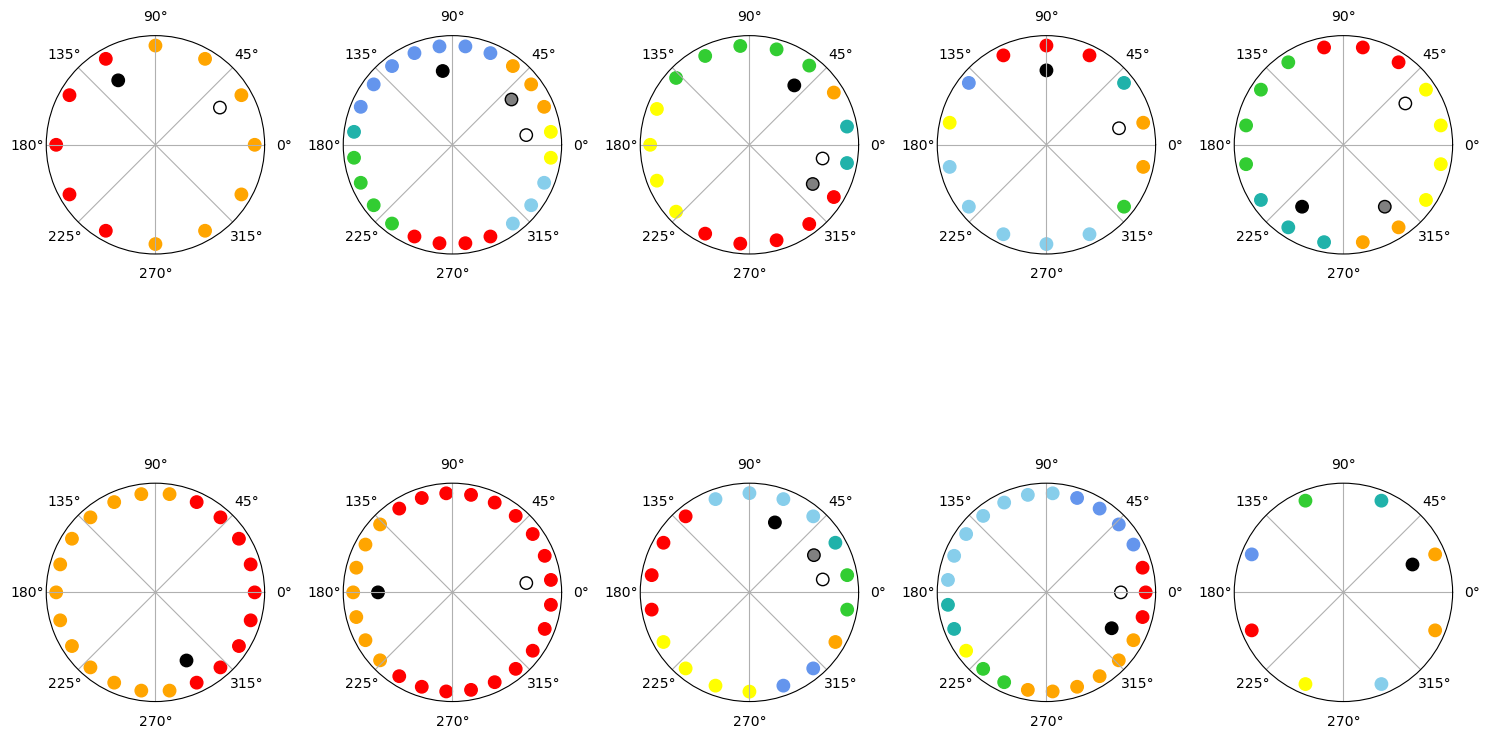

In [1232]:
n_trials_to_plot = 10
fig, axs = plt.subplots(2, int(n_trials_to_plot/2), figsize=(3*(n_trials_to_plot/2), 5*2), subplot_kw=dict(projection="polar"), dpi=100)
def plot_trial(axs, trial):    
    theta = np.linspace(0, 2 * np.pi, endpoint=False, num = trial['n_items'])
    occ_circle = trial['occ_circle']
    map_circle = trial['map_circle']
    target_start = (np.flatnonzero(map_circle == trial['target_color'])[0] + trial['rot']) % trial['n_items']
    target_com = (target_start + (trial['n_target']-1)/2) % trial['n_items']
    theta = theta - target_com*2*np.pi/trial['n_items']
    occ_circle_colors = [_COLORS[color] for color in occ_circle]
    axs.scatter(theta, np.ones(trial['n_items']) * 0.2, color=occ_circle_colors, s=80)
    angles = np.linspace(0, 2 * np.pi, endpoint=False, num = trial['n_items'])[trial['attempt_thetas']]   - target_com*2*np.pi/trial['n_items']
    angle_colors = cm.get_cmap('gray')(np.linspace(0,1,num=len(angles),endpoint=True))
    axs.scatter(angles, np.repeat(0.15, len(angles)), color=angle_colors, s=80, edgecolor='black') 
    axs.set_rticks([])
    axs.set_rmin(0)
    axs.set_rmax(.22)
trials_to_plot = data.sample(n_trials_to_plot)
for ax, (idx, trial) in zip(axs.flat, trials_to_plot.iterrows()):
    plot_trial(ax, trial)

plt.tight_layout()

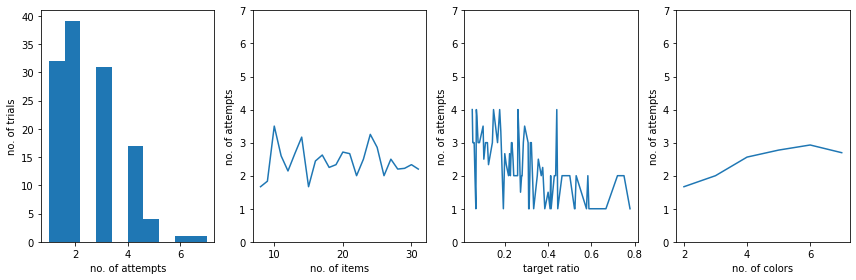

In [1231]:
def plot_attempts(trials):
    """Plots attempts as a function of ratio"""
    trials = trials.copy()
    fig, ax = plt.subplots(1, 4, figsize=(3 * 4, 4))
    y_min, y_max = [0, trials['n_attempts'].max()]
    for a in ax[1:]:
        a.set_ylim([y_min, y_max])

    ax[0].hist(trials['n_attempts'])
    ax[0].set_xlabel('no. of attempts')
    ax[0].set_ylabel('no. of trials')

    ax[2].plot(trials.groupby('frac_target')['n_attempts'].mean())
    ax[2].set_xlabel('target ratio')
    ax[2].set_ylabel('no. of attempts')

    ax[1].plot(trials.groupby('n_items')['n_attempts'].mean())
    ax[1].set_xlabel('no. of items')
    ax[1].set_ylabel('no. of attempts')

    ax[3].plot(trials.groupby('n_colors')['n_attempts'].mean())
    ax[3].set_xlabel('no. of colors')
    ax[3].set_ylabel('no. of attempts')

    plt.tight_layout()
plot_attempts(data)

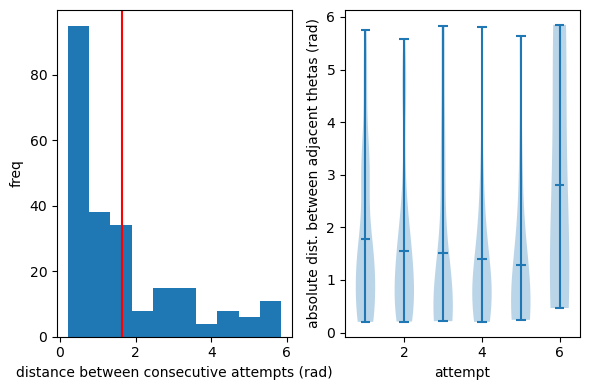

In [1248]:
def plot_dist_attempts(trials):
    fig, ax = plt.subplots(1, 2, figsize=(3*2, 4), dpi=100)
    dist_theta = []
    dist_theta_attempts = [[] for attempt in range(trials['n_attempts'].max()-1)]
    for idx, trial in trials.iterrows():
        dist_theta.append(2 * np.pi * trial['dist_theta']/trial['n_items'])
        for attempt in range(len(trial['dist_theta'])):
            dist_theta_attempts[attempt].append(2 * np.pi * trial['dist_theta'][attempt]/trial['n_items'])
    dist_theta = [np.abs(dist) for sublist in dist_theta for dist in sublist]
    ax[0].axvline(np.mean(dist_theta), color='red')
    ax[0].hist(dist_theta)
    ax[0].set_xlabel('distance between consecutive attempts (rad)')
    ax[0].set_ylabel('freq')

    dist_theta_attempts = [np.abs(np.asarray(sublist)) for sublist in dist_theta_attempts]
    ax[1].violinplot(dist_theta_attempts, np.arange(1, trials['n_attempts'].max()), showmeans=True)
    ax[1].set_xlabel('attempt')
    ax[1].set_ylabel('absolute dist. between adjacent thetas (rad)')
    plt.tight_layout()
    plt.show()
plot_dist_attempts(data)